<a href="https://colab.research.google.com/github/DJLee68/MachineLearningProject/blob/master/Assignment09/DJLee_Assignment09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
from torchvision import transforms, utils, datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)


In [8]:
 class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [10]:
criterion = nn.NLLLoss()
classifier = classification().to(GPU)
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value)

NameError: ignored

## Output using the dataset

1. Plot the original data points [1pt]

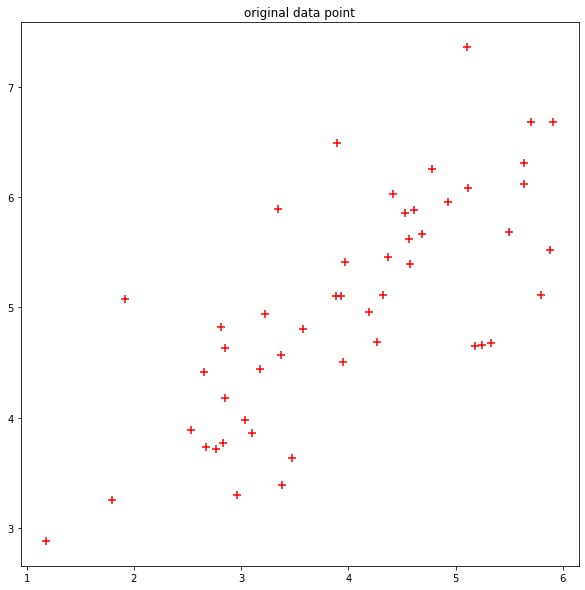

In [ ]:
# plot data
plt.figure(1,figsize=(10,10))
plt.scatter(x, y, s=50, c='red', marker='+') 
plt.title('original data point')
plt.show()

2. Plot the normalized data points [1pt]

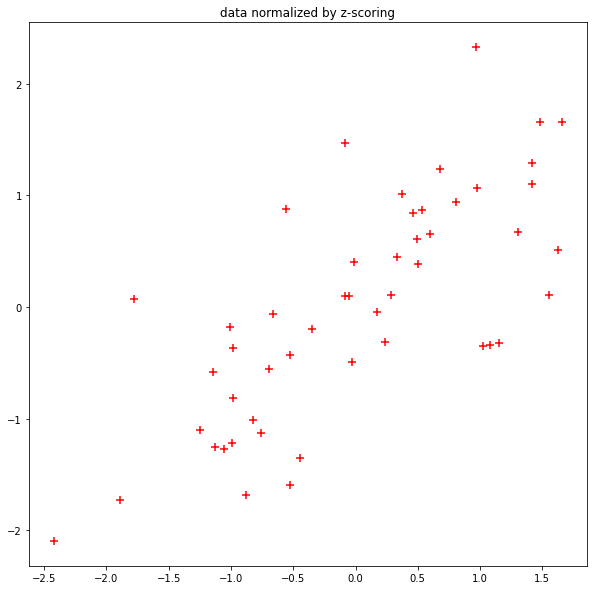

In [ ]:
plt.figure(2,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.title('data normalized by z-scoring')
plt.show()

3. Plot the principal axes [2pt]

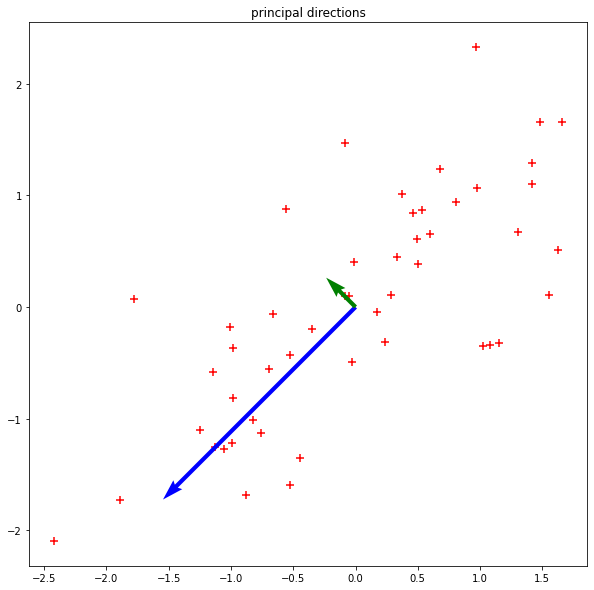

In [ ]:
plt.figure(3,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.quiver(0,0,-c[0][0], c[1][0], scale = e_value[1], scale_units = 'inches', color='b')
plt.quiver(0,0,-c[0][1], c[1][1], scale = e_value[0], scale_units = 'inches', color='g')
plt.title('principal directions')
plt.show()


4. Plot the first principal axis [3pt]

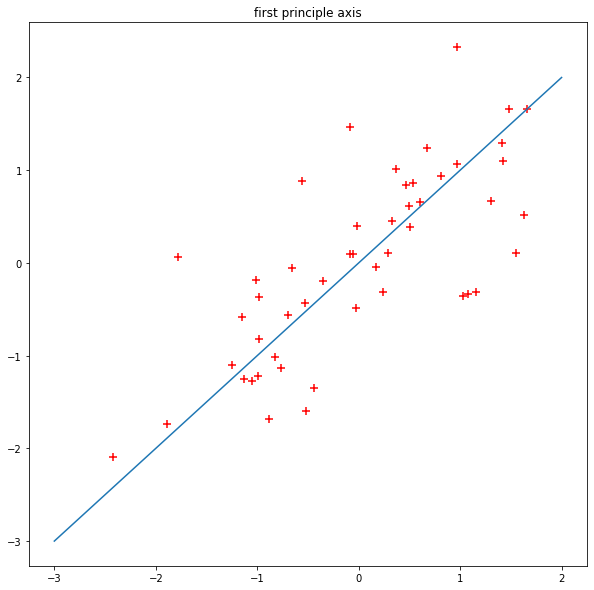

In [ ]:
plt.figure(4,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.plot(x1, y1)
plt.title('first principle axis')
plt.show()

5. Plot the project of the normalized data points onto the first principal axis [4pt]

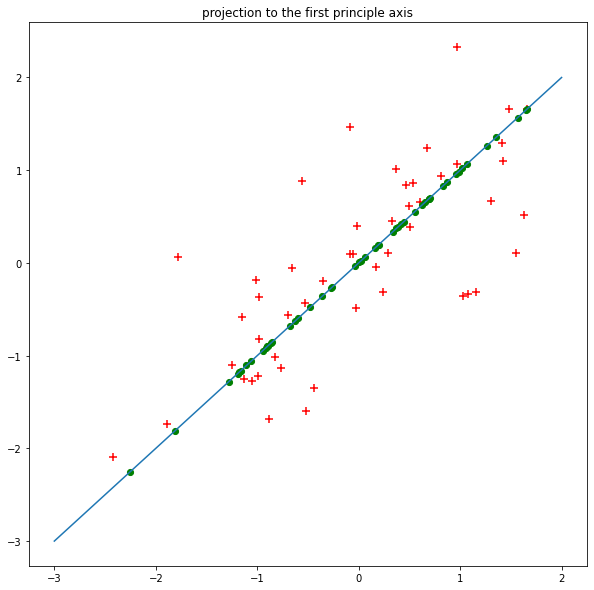

In [ ]:
plt.figure(5,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.plot(x1, y1)
plt.scatter(project_point[:,0], project_point[:,1], s=150, c='g', marker='.') 
plt.title('projection to the first principle axis')
plt.show()

6. Plot the lines between the normalized data points and their projection points on the first principal axis [3pt]



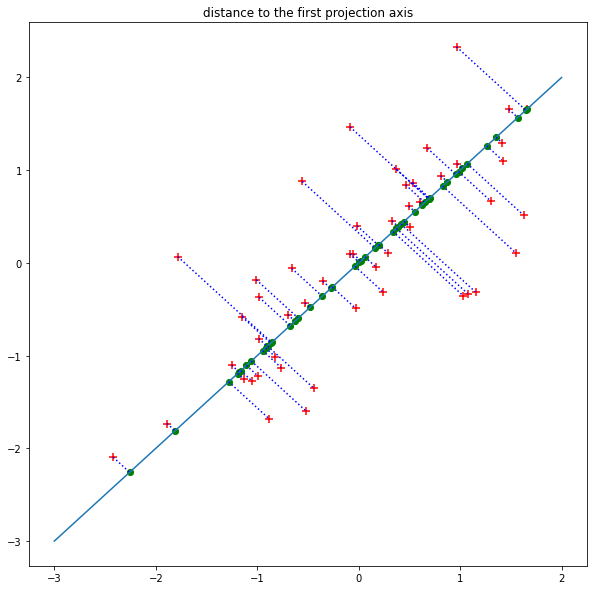

In [ ]:
plt.figure(6,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.plot(x1, y1)
plt.scatter(project_point[:,0], project_point[:,1], s=150, c='g', marker='.') 

for i in range(len(xn)): #{
  tmp_xn = xn[i][0]
  tmp_yn = yn[i][0]

  project_x = np.arange(min(tmp_xn, project_point[i][0]), max(tmp_xn, project_point[i][0]), step=0.01)  
  project_y = reverse_delta*(project_x - tmp_xn) + tmp_yn
  plt.plot(project_x, project_y, color='b', linestyle=':')  
#}
plt.title('distance to the first projection axis')
plt.show()

7. Plot the second principal axis [3pt]

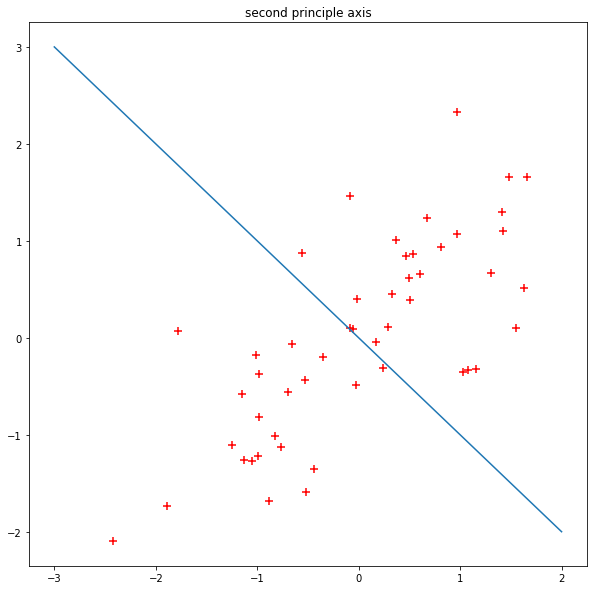

In [ ]:
plt.figure(7,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.plot(x2, y2)
plt.title('second principle axis')
plt.show()


8. Plot the project of the normalized data points onto the second principal axis [4pt]

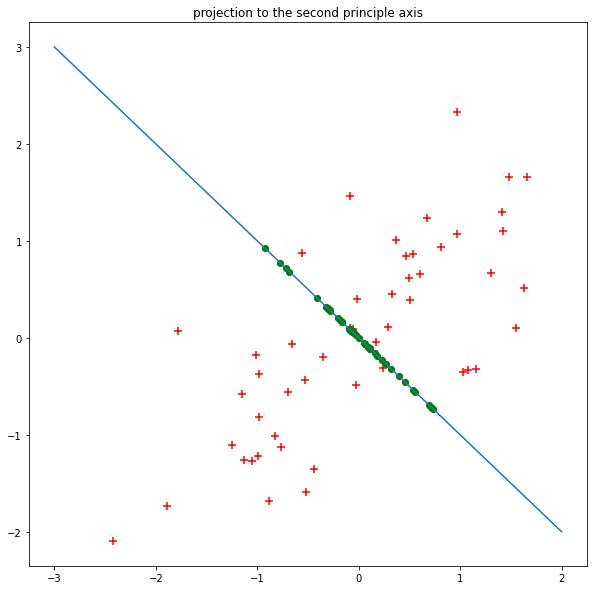

In [ ]:
plt.figure(8,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.plot(x2, y2)
plt.scatter(project_point2[:,0], project_point2[:,1], s=150, c='g', marker='.') 
plt.title('projection to the second principle axis')
plt.show()

9. Plot the lines between the normalized data points and their projection points on the second principal axis [3pt]

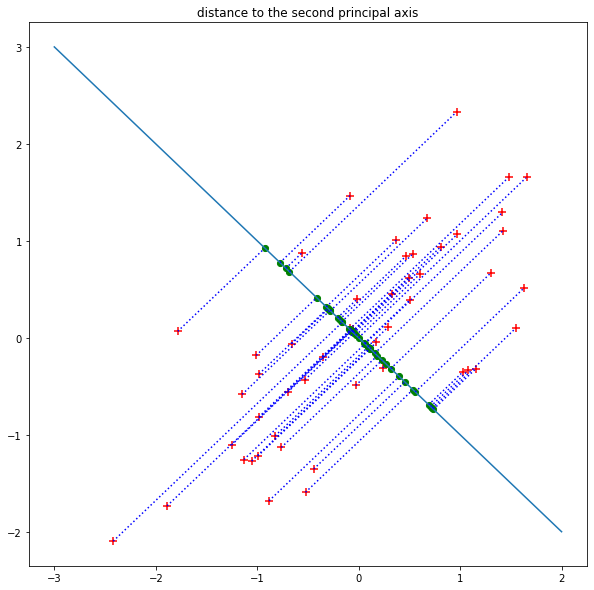

In [ ]:
plt.figure(9,figsize=(10,10))
plt.scatter(xn, yn, s=50, c='red', marker='+') 
plt.plot(x2, y2)
plt.scatter(project_point2[:,0], project_point2[:,1], s=150, c='g', marker='.') 

for i in range(len(xn)): #{
  tmp_xn = xn[i][0]
  tmp_yn = yn[i][0]
  project_x = np.arange(min(tmp_xn, project_point2[i][0]), max(tmp_xn, project_point2[i][0]), step=0.01)  
  project_y = slope*(project_x - tmp_xn) + tmp_yn
  plt.plot(project_x, project_y, color='b', linestyle=':')  
#}
plt.title('distance to the second principal axis')
plt.show()